In [1]:
%cd learners

/home/buehrle/dev/InteractionImitation/scratch/etienne/pillbox/learners


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch

In [5]:
from intersim_advil import IntersimPolicy, IntersimDiscriminator
from train import train_advil

pi = train_advil(
    'intersim:intersim-v0',
    policy_class=IntersimPolicy,
    discriminator_class=IntersimDiscriminator,
    iters=1500,
    lr_pi=2e-5,
    lr_f=8e-4,
)

Vehicle Trajectory Paths: datasets/trackfiles/DR_USA_Roundabout_FT/vehicle_tracks_000.csv
Map Path: datasets/maps/DR_USA_Roundabout_FT.osm


  0%|                                                                                                          | 1/1500 [00:00<13:48,  1.81it/s]

pi loss: 0.8109868082717183
mse reg: 0.9072583226644249
f loss: -0.0031385235927202104


  7%|███████                                                                                                 | 101/1500 [02:08<42:38,  1.83s/it]

pi loss: 1.302757262220359
mse reg: 0.7177222434486094
f loss: -0.13115944605799967


 10%|██████████▍                                                                                             | 151/1500 [03:05<22:08,  1.02it/s]/workspaces/pillbox/learners/advil.py:118: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(pi.parameters(), 40.0)
/workspaces/pillbox/learners/advil.py:145: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(f.parameters(), 40.0)
 13%|█████████████▉                                                                                          | 201/1500 [03:55<20:10,  1.07it/s]

pi loss: 7.271015700900185
mse reg: 0.5915718820988135
f loss: -1.4101360479975682


 18%|██████████████████▋                                                                                     | 269/1500 [04:58<22:45,  1.11s/it]


KeyboardInterrupt: 

In [12]:
torch.save(pi.state_dict(), 'intersim:intersim-v0/advil_policy.pt')

In [13]:
# pi = IntersimPolicy(env=None)
# pi.load_state_dict(torch.load('intersim:intersim-v0/advil_policy.pt'))

In [19]:
import gym
from tqdm import tqdm

def rollout(pi, max_steps=1000):
    env = gym.make('intersim:intersim-v0')
    obs, _ = env.reset()
    
    _except = lambda o, i: torch.cat((o[:i], o[i+1:]))
    
    _relative_state_v = lambda obs: torch.stack((
        obs[..., 0],
        obs[..., 1],
        (obs[..., 2]**2 + obs[..., 3]**2).sqrt(),
        obs[..., 4],
        obs[..., 5],
    ), -1)
    
    for i in tqdm(range(max_steps)):
        pi_obs = torch.stack(tuple(
            torch.cat((e.unsqueeze(0), _relative_state_v(_except(o, i))))
            for i, (e, o) in enumerate(zip(obs['state'], obs['relative_state']))
        ))
        
        actions = pi(pi_obs)
        obs, _, done, _ = env.step(actions)
        env.render(mode='post')
        if done:
            break
    env.close()

Vehicle Trajectory Paths: datasets/trackfiles/DR_USA_Roundabout_FT/vehicle_tracks_000.csv
Map Path: datasets/maps/DR_USA_Roundabout_FT.osm
Environment Reset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 15.53it/s]


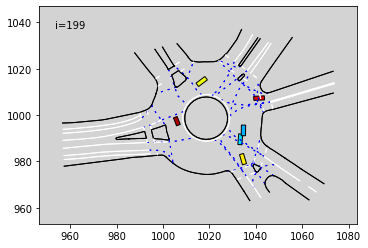

In [20]:
pi.eval()
rollout(pi, max_steps=200)